<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/ThinFromThick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#load data
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

!rm -rf ./sample_data
!rm -rf ./thin_images
import os
import nibabel as nib
import numpy as np
#import Imageio
import PIL
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy import ndimage
from scipy.ndimage import zoom
import time
#import pyyaml 
import h5py
import random
import math

#!wget -c --tries=75 --no-check-certificate 'https://docs.google.com/uc?export=download&id=gfqd52CeJGyex-QVtepCOjRLOXBwfDW0' -O ./3DVols.zip
!mkdir ./3DVols
!mv ./3DVols.zip ./3DVols
!cd 3DVols; unzip -q "./3DVols" 
DIR = '/Users/bje01/Desktop/3DVols/'
DIR = './3DVols/'

NPY_FILE = DIR+"ThinVols.npy"
# Then load into arrays
flist = os.listdir(DIR)
print (flist)



CREATE_IMAGES = False   # whether to create all the images else load them
SAVE_IMAGES = False

DIM = 256  # assuming MRI  note that will make into a 3D vol of this size
ZD = 128
Z_FAC = 5  # interpolate by factor of 5 in z direction
MAX_VOLS = 10
MAX_VAL = 10000


['Vol7.nii', 'Vol5.nii', 'Vol4.nii', '__MACOSX', '3DVols.zip', 'Vol8.nii', 'Vol1.nii', 'Vol9.nii', 'Vol3.nii', 'Vol6.nii', 'Vol2.nii']


In [2]:

#!cat /proc/cpuinfo
#!cat /proc/meminfo

!nvidia-smi


Mon Mar 23 01:08:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# New Section

In [0]:

def rescale_img(image, max_val=MAX_VAL):
    image = image - np.min(image)
    image = (np.maximum(image, 0) / image.max()) * max_val
    return (image)


def save_it(img, fname):
    img = rescale_img(img, max_val=255)
#    print ("Save max: " + str(img.max()))
    dims = np.shape(img)
    # print (dims)
    if dims[0] < 128:
        im = zoom(img, (DIM/dims[0], DIM/dims[1]))
        im = PIL.Image.fromarray(np.uint8(im))
        im = im.convert("L")  # or 'RGB'
        im.save(fname+".png")
        return

    if (dims[0] != DIM) or (dims[1] != DIM):  # make consistent size
        tmp = np.zeros((DIM, DIM), dtype=np.int16)
        for y in range(min(dims[1], DIM)):
            tmp[:,y] = img[:min(DIM, dims[0]),y].reshape(min(DIM, dims[0]))
    else:
        tmp = img
#    z = np.rot90(z)   # adjust for the way numpy handles image data
#    z = np.rot90(z)   # adjust for the way numpy handles image data
#    z = np.rot90(z)   # adjust for the way numpy handles image data
    im = PIL.Image.fromarray(np.uint8(tmp))
    im = im.convert("L")  # or 'RGB'
    im.save(fname+".png")
#    print ("Saved " + fname)


In [4]:
thins = np.zeros (DIM * DIM * ZD * MAX_VOLS)
thins = thins.reshape(DIM, DIM, ZD* MAX_VOLS)
slc_cnt = 0
!rm *.png

CREATE_IMAGES = True
if CREATE_IMAGES == False:
        # read in already created 3D vols
    thins = np.load(NPY_FILE)
    print ("Loaded existing thinvols")
    slc_cnt = 1152
else:
    for f in flist:
        if 'nii' in f:
            print (os.path.join(DIR, f))
            try:
                nifti = nib.load(os.path.join(DIR, f))
                image = nifti.get_fdata()
                dims = image.shape
#                print ("Original Dims: " + str(dims))
#                print ("Original Max: " + str(image.max()))
                image = ndimage.median_filter(image, size=(3,3,1))
                image = zoom(image, (DIM/dims[0], DIM/dims[1], ZD/dims[2]))
                image = rescale_img(image, max_val = 20000)
                dims = image.shape
#                print ("New Dims: " + str(dims))
                xd = dims[0]
                yd = dims[1]
                zd = dims[2]
                for z in range(zd):
                    thins[:,:,slc_cnt] = image[:,:,z].copy().astype(np.int16)
                    slc_cnt += 1
            except:
                print ("exception on " + f)
            print (str(slc_cnt))

    print ("Total vols: " + str(thins.shape))
    np.save (NPY_FILE, thins)



print (str(thins.max()) + " with " + str(slc_cnt) + " actual slices saved.")

rm: cannot remove '*.png': No such file or directory
./3DVols/Vol7.nii
128
./3DVols/Vol5.nii
256
./3DVols/Vol4.nii
384
./3DVols/Vol8.nii
512
./3DVols/Vol1.nii
640
./3DVols/Vol9.nii
768
./3DVols/Vol3.nii
896
./3DVols/Vol6.nii
1024
./3DVols/Vol2.nii
1152
Total vols: (256, 256, 1280)
20000.0 with 1152 actual slices saved.


In [5]:
# now make axial thicks from the thins
# note that there will be 1 thick for each thin--it is a moving window

XD = DIM
!rm *.png
# now put each into a large 3D array

thick_slices = int(slc_cnt / Z_FAC)
thicks = np.zeros (DIM * DIM * thick_slices)
thicks = thicks.reshape(DIM, DIM, thick_slices)
thins = rescale_img(thins)

for z in range(thick_slices):
    s = z * Z_FAC + 2
    thicks[:,:,z] = (thins[:,:,s-2] + thins[:,:,s-1] + thins[:,:,s] + thins[:,:,s+1] + thins[:,:,s+2]) / 5.0
    if (z % 50 == 0):
        save_it(thicks[:,:,z], DIR+"thick{}".format(z))

# thicks = rescale_img(thicks)
print (str(thick_slices)+ " thick slices and thin slices: " + str(slc_cnt))


rm: cannot remove '*.png': No such file or directory
230 thick slices and thin slices: 1152


Thins:  (256, 256, 1280)
Thicks:  (256, 256, 230)


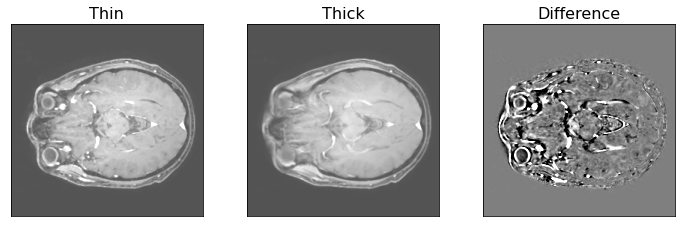

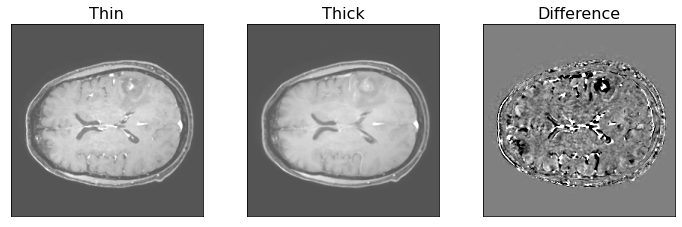

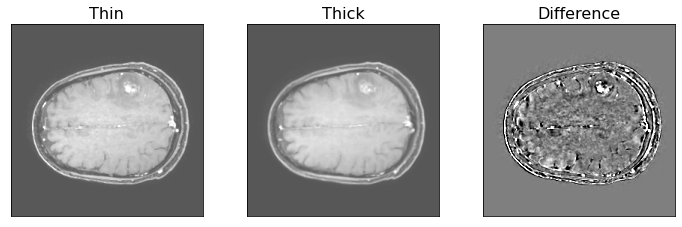

In [6]:


def imgshow(img):
  ww = max(100, 5.0 * img.std())
  wl = img.mean()

  # Plot image on clean axes with specified window level
  vmin = wl - ww // 2
  vmax = wl + ww // 2

  plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
  plt.xticks([])
  plt.yticks([])
  return

def thick_to_thin(slc):
    return (int(slc * Z_FAC + 2))

for row in range(3):
  plt.figure(figsize=(12, 12))
  # Simulated low-dose example
  plt.subplot(3, 3, 1+row*3)
  plt.title('Thin', fontsize=16)
  imgshow(thins[:, :, thick_to_thin(60+3*row)])

  # Simulated routine-dose example
  plt.subplot(3, 3, 2+row*3)
  plt.title('Thick', fontsize=16)
  imgshow(thicks[:, :, 60+3*row])
  plt.subplot(3, 3, 3+row*3)

  # Difference between low-dose and routine-dose to visualize CT noise
  plt.title('Difference', fontsize=16)
  imgshow(thins[:, :, thick_to_thin(60+3*row)] - thicks[:, :, 60+3*row])
print ("Thins:  " + str(thins.shape))
print ("Thicks:  " + str(thicks.shape))



rm: cannot remove './*.png': No such file or directory
(256, 256, 230)
50000 patches created.


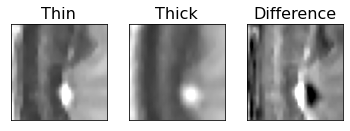

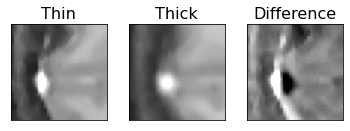

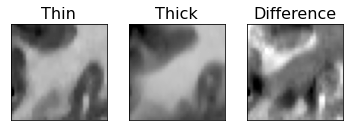

In [7]:
# now take patches from the complete volumes
patch_XD = 32 # and YD
patch_ZD = 5
max_patches = 50000 # was 50000
skip = 4 # skip along X and Y too
!rm ./3DVols/*.png
!rm ./*.png

print (str(thicks.shape)) # stil X, Y, Z format
thick_patches = np.zeros (max_patches * patch_XD * patch_XD * patch_ZD)
thin_patches  = np.zeros (max_patches * patch_XD * patch_XD * patch_ZD)
thick_patches = thick_patches.reshape(max_patches, patch_XD, patch_XD, patch_ZD)
thin_patches  = thin_patches.reshape (max_patches, patch_XD, patch_XD, patch_ZD)

DEBUG = False
patch_cnt = 0
bound = 12 # number of pixels to use as X/Y boundary
for z in range (5, thick_slices - patch_ZD - 5):
    for y in range(bound, DIM-patch_XD-bound, skip):
        for x in range(bound, DIM-patch_XD-bound, skip):
            #print (str(x) + ", " + str(y) + ", " + str(z))
            if patch_cnt < max_patches and np.mean(thicks[y:y+patch_XD, x:x+patch_XD, z:z+patch_ZD]) > MAX_VAL / 5:
                tz = thick_to_thin(z+2) # add 2 to get to center of patch
                thick_patches[patch_cnt,:,:,:] = thicks[x:x+patch_XD, y:y+patch_XD, z:z+patch_ZD]
                thin_patches [patch_cnt,:,:,:] = thins [x:x+patch_XD, y:y+patch_XD, tz:tz+patch_ZD]

                if (patch_cnt % 5000 == 0) and DEBUG:
                    print ("Z: " + str(z) + " tz: " + str(tz))
                    save_it(thin_patches [patch_cnt, :, :, 0], "./thinpatch{}-0".format(patch_cnt))
                    save_it(thin_patches [patch_cnt, :, :, 1], "./thinpatch{}-1".format(patch_cnt))
                    save_it(thin_patches [patch_cnt, :, :, 2], "./thinpatch{}-2".format(patch_cnt))
                    save_it(thin_patches [patch_cnt, :, :, 4], "./thinpatch{}-4".format(patch_cnt))
                    save_it(thin_patches [patch_cnt, :, :, 3], "./thinpatch{}-3".format(patch_cnt))
                    save_it(thick_patches[patch_cnt, :, :, 0], "./thickpatch{}-0".format(patch_cnt))
                    save_it(thick_patches[patch_cnt, :, :, 1], "./thickpatch{}-1".format(patch_cnt))
                    save_it(thick_patches[patch_cnt, :, :, 2], "./thickpatch{}-2".format(patch_cnt))
                    save_it(thick_patches[patch_cnt, :, :, 3], "./thickpatch{}-3".format(patch_cnt))
                    save_it(thick_patches[patch_cnt, :, :, 4], "./thickpatch{}-4".format(patch_cnt))
                patch_cnt += 1  # move this below saves if uncommented

print (str(patch_cnt) + " patches created.")

for row in range(3):
  plt.figure(figsize=(6, 6))
  plt.subplot(3, 3, 1+row*3)
  plt.title('Thin', fontsize=16)
  imgshow(thin_patches[row*30+10, :, :, 2])

  plt.subplot(3, 3, 2+row*3)
  plt.title('Thick', fontsize=16)
  imgshow(thick_patches[row*30+10, :, :, 2])
  plt.subplot(3, 3, 3+row*3)

  plt.title('Difference', fontsize=16)
  imgshow(thin_patches[row*30+10, :, :, 2] - thick_patches[row*30+10, :, :, 2])

In [0]:
# now randomize order of patches but thin and thick must stay matched
# use same seed so train and valid stay constant accross runs

random.seed(a=42, version=2)

for p in range(patch_cnt):
    r = random.randrange(0,patch_cnt)

    hold = thin_patches[p]
    thin_patches[p] = thin_patches[r]
    thin_patches[r] = hold

    hold = thick_patches[p]
    thick_patches[p] = thick_patches[r]
    thick_patches[r] = hold

#np.save ("./Thin_Patches", thin_patches)
#np.save ("./Thick_Patches", thick_patches)

Thicks before swap:  (50000, 32, 32, 5)
 after swap:  (50000, 5, 32, 32)


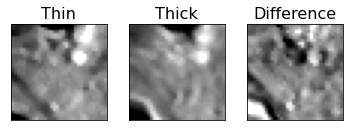

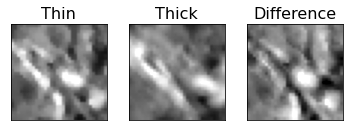

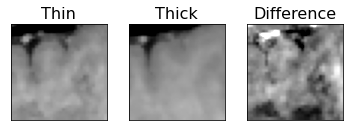

In [9]:
# now need to re-order axes of the thicks and thins to be compatible with tensorflow
print ("Thicks before swap:  " + str(thin_patches.shape))
nthins = np.moveaxis(thin_patches, -1, 1)
#nthins = np.moveaxis(nthins, 3, 1)
nthicks = np.moveaxis(thick_patches, -1, 1)
print (" after swap:  " + str(nthins.shape))


for row in range(3):
  plt.figure(figsize=(6, 6))
  plt.subplot(3, 3, 1+row*3)
  plt.title('Thin', fontsize=16)
  imgshow(nthins[row* 70, 3, :, :])

  plt.subplot(3, 3, 2+row*3)
  plt.title('Thick', fontsize=16)
  imgshow(nthicks[row* 70, 3, :, :])
  plt.subplot(3, 3, 3+row*3)

  plt.title('Difference', fontsize=16)
  imgshow(nthins[row* 70, 3, :, :] - nthicks[row* 70, 3, :, :])


Num_Train = int(patch_cnt * 0.8)
Num_Test = 25
Num_Val = patch_cnt - Num_Train - Num_Test

train_input = nthicks[0:Num_Train,:,:]
train_target = nthins[0:Num_Train,:,:]
train_input = train_input[..., np.newaxis]
train_target = train_target[..., np.newaxis]

val_input = nthicks[Num_Train:Num_Train + Num_Val,:,:]
val_target = nthins[Num_Train:Num_Train + Num_Val,:,:]
val_input = val_input[..., np.newaxis]
val_target = val_target[..., np.newaxis]

test_input = nthicks[-Num_Test:,:,:]
test_target = nthins[-Num_Test:,:,:]
test_input = test_input[..., np.newaxis]
test_target = test_target[..., np.newaxis]

# for preprocessing
#shift_mean = train_input.mean()
#rescale = train_input.std()


In [0]:

%tensorflow_version 1.x 
import tensorflow as tf
from tensorflow import keras

n_layers = 6 
filters = 32
kernel_size = (5,5,5)
strides = (1, 1, 1) 
activation = 'relu'

def build_model():
    xin = keras.layers.Input(shape=(None, None, None, 1), name='input_images')
    
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)
    
    for i in range(n_layers - 1):
        x = keras.layers.Conv3D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)

    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv3D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_images')(x)
    
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="thin_from_thick")
    return model




In [0]:
print ("Training set shape:  " + str(train_input.shape))
print ("Training target shape:  " + str(train_target.shape))
thinning_model = build_model()
#thinning_model.summary()
fname = './best_model.h5'
if os.path.exists(fname):
    print ("Loading existing model")
    thinning_model.load_weights(fname)

batch_size = 1024

def train(loss_function, model):
    best_lost = 100000000000000
    
#    for learning_rate in [0.001, 0.0003, 0.0001, 0.00003, 0.001, 0.003, 0.00001]:
    for learning_rate in [0.0001, 0.00003, 0.00001]:
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(optimizer=optimizer, loss="mse")
        best_epoch = -1
        epoch = -1

#        for epoch in range(epochs):  
        while epoch-best_epoch < 20:   # keep doing epochs at this lr until no progress
            # Evaluate model on reserved data
            epoch += 1
            val_loss = model.evaluate(val_input, val_target)
            if val_loss < best_lost:
                fname = './best_model.h5'.format(epoch)
#                print ("NEW BEST: " + str(val_loss) + " at epoch " + str(epoch))
                print ("NEW BEST: " + str(val_loss) + "   Sqrt error/pixel: " + str(math.sqrt(val_loss/Num_Val)) + " at epoch " + str(epoch))
                model.save_weights(fname)
                best_lost = val_loss
                best_epoch = epoch

            # Update model weights using training data
            istart = 0
            start_time = time.time()
            while istart < (len(train_input) - batch_size):
                x = train_input[istart:istart + batch_size]
                y = train_target[istart:istart + batch_size]
                model.train_on_batch(x=x, y=y)
                istart += batch_size
            if (epoch % 10 == 0):
                print ("LearningRate {} Epoch {} required {} seconds".format(learning_rate, epoch, int(time.time()-start_time)))
#                example_output = model.predict(test_input)
                # print (example_output.shape)
#                for ex in range(5):
#                    for z in range (5):
#                        save_it(example_output[ex, z, :,:], DIR+"out-{}-{}-ep{}".format(ex, z, best_lost))
    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, progress_ims, progress_val


# Now run the training fuction to obtain the trained model and performance at
# intermediate steps
thinning_model, progress_ims, progress_val = train(loss_function='mse', model=thinning_model)

Training set shape:  (40000, 5, 32, 32, 1)
Training target shape:  (40000, 5, 32, 32, 1)
Loading existing model
9975/9975 [==============================] - 7s 661us/sample - loss: 57414.2607
NEW BEST: 57414.26068687344   Sqrt error/pixel: 2.399128093226081 at epoch 0
LearningRate 0.0001 Epoch 0 required 81 seconds
9975/9975 [==============================] - 7s 656us/sample - loss: 56925.3273
NEW BEST: 56925.32730968045   Sqrt error/pixel: 2.388890899621366 at epoch 1
9975/9975 [==============================] - 7s 655us/sample - loss: 56566.3611
NEW BEST: 56566.36112233709   Sqrt error/pixel: 2.3813469182579112 at epoch 2
9975/9975 [==============================] - 7s 657us/sample - loss: 56399.2248
NEW BEST: 56399.224765037594   Sqrt error/pixel: 2.377826238511794 at epoch 3
9975/9975 [==============================] - 7s 654us/sample - loss: 56270.9428
NEW BEST: 56270.94281798245   Sqrt error/pixel: 2.3751204758886884 at epoch 4
9975/9975 [==============================] - 7s 659u

In [0]:
# Show example images from different epochs.

plt.figure(figsize=(12, 12))

skip = len(progress_ims) // 8
for i in range(8):
    plt.subplot(2, 4, i+1)
    imgshow(progress_ims[i*skip, :, :])  #evens are input, odds are output



In [0]:
# Display an example input image, the interpolated image
nexample = 1
CNNout = thinning_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))


for row in range(5):
  plt.figure(figsize=(12, 12))
  plt.subplot(3, 3, 1+row)
  plt.title('Input', fontsize=16)
  imgshow(CNNout[0,row,:,:,0])



In [0]:

# Save the weights
thinning_model.save_weights('./thick_to_thin_model')

# Create a new model instance
#model = create_model()

# Restore the weights
#model.load_weights('./checkpoints/my_checkpoint')

